In [1]:
import matplotlib
import matplotlib.pyplot as plt

/usr/local/lib/python3.12/dist-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
from experiments import *
from dd_solvers import *

AMGX version 2.5.0
Built on Jul  5 2025, 09:37:04
Compiled with CUDA Runtime 12.6, using CUDA driver 12.7
The AMGX_initialize_plugins API call is deprecated and can be safely removed.


In [3]:
def run_experiments(base_mesh, test_case, n, k):
    mesh_family = MeshFamily.refinements(
        base=base_mesh,
        n=n,
    )
    hmaxs = [mesh_family[i].h.max() for i in range(n)]

    all_results = []

    for kk in range(1, k + 1):
        factory = ExperimentFactory(
            test_case=test_case,
            mesh_family=mesh_family,
            polynomial_degree=kk,
            number_of_repetitions=1,
            error_continuous_norms=(2,),
        )

        for i in range(n):
            factory.add(
                Experiment(
                    fine_m=i,
                    solvers_m=None,
                    coarse_m=None,
                    solver=CUDSS(),
                    allow_tf32=True,
                )
            )

        all_results.append(factory.run())

    return all_results, hmaxs

In [23]:
def plot_results(results, hmaxs, title):
    def set_log_locator(axis):
        axis.set_major_locator(
            matplotlib.ticker.LogLocator(base=2, subs="all", numticks=20)
        )
        axis.set_minor_locator(
            matplotlib.ticker.LogLocator(base=2, subs="all", numticks=50)
        )
        axis.set_major_formatter(matplotlib.ticker.LogFormatterSciNotation(base=2))
        axis.set_minor_formatter(matplotlib.ticker.NullFormatter())

    fig, ax = plt.subplots(figsize=(9, 6))
    for k in range(1, len(results) + 1):
        df = results[k - 1].sort_values(by="fine m")
        errors = list(df["error L2 norm"])
        ax.plot(hmaxs, errors, label=f"k={k}")
        ax.scatter(hmaxs, errors)
    ax.set_xscale("log")
    set_log_locator(ax.xaxis)
    ax.set_yscale("log")
    set_log_locator(ax.yaxis)
    ax.invert_xaxis()
    ax.set_xlabel("Mesh $h_{max}$")
    ax.set_ylabel("Error $L_2$ norm")
    ax.set_title(title)
    ax.grid(which="major", linewidth=1)
    ax.grid(which="minor", linewidth=0.2, color="gray")
    ax.legend()
    fig.show()

In [16]:
results_2d = run_experiments(
    Mesh2D.unit_square_uniform(1, 1), continuous_coefficient_2d, n=9, k=4
)

Running experiments: 100%|██████████| 9/9 [00:11<00:00,  1.31s/it]


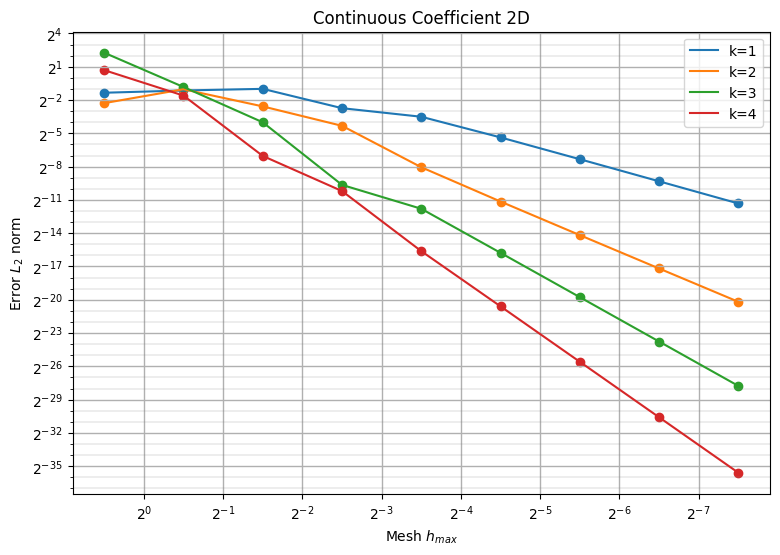

In [24]:
plot_results(*results_2d, title="Continuous Coefficient 2D")

In [32]:
results_3d = run_experiments(
    Mesh3D.unit_cube_uniform(1, 1, 1), constant_coefficient_3d, n=6, k=2
)

Running experiments: 100%|██████████| 6/6 [00:24<00:00,  4.04s/it]


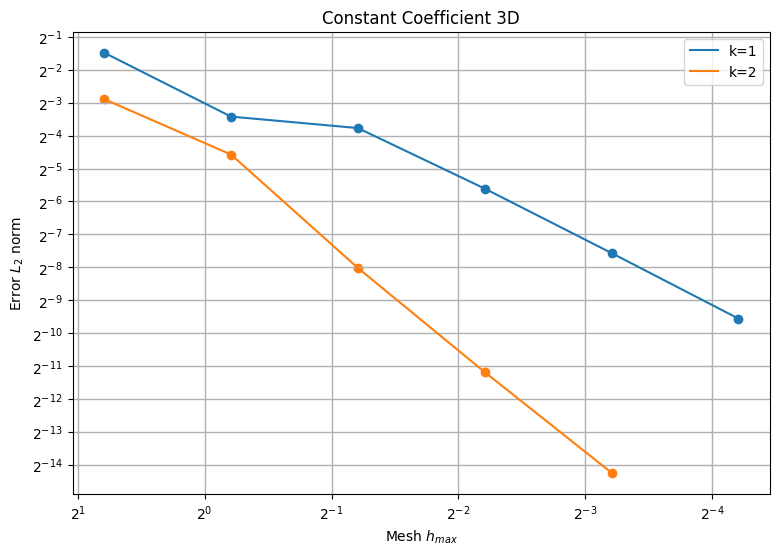

In [33]:
plot_results(*results_3d, title="Constant Coefficient 3D")